In [17]:
import random
import torch
from typing import Tuple
import triton
import pandas as pd
from fp8_gemm import DeepLinear, deep_matmul
from copy import deepcopy

# 精度

In [19]:
device = 'cuda'
dtype = torch.bfloat16
m, n, k = 4096, 4096, 4096
x1 = torch.randn(m, k, dtype=dtype, device=device)
x1.requires_grad_(True)
x2 = deepcopy(x1)
fc1 = torch.nn.Linear(k,n, bias=False, dtype=dtype, device=device)
fc2 = DeepLinear(k,n, bias=False, dtype=dtype, device=device)
fc2.weight.data.copy_(fc1.weight.data)

tensor([[-0.0156, -0.0045, -0.0099,  ..., -0.0146,  0.0082, -0.0096],
        [-0.0090, -0.0155,  0.0027,  ...,  0.0138, -0.0113,  0.0121],
        [-0.0118,  0.0001, -0.0007,  ...,  0.0136,  0.0046, -0.0046],
        ...,
        [-0.0151, -0.0007,  0.0033,  ..., -0.0085, -0.0018,  0.0014],
        [-0.0137, -0.0106,  0.0127,  ...,  0.0011, -0.0134, -0.0113],
        [-0.0015,  0.0070, -0.0101,  ..., -0.0132, -0.0021,  0.0118]],
       device='cuda:0', dtype=torch.bfloat16)

In [13]:
y1 = fc1(x1)
y2 = fc2(x2)
dy = torch.randn_like(y1)
y1.backward(dy)
y2.backward(dy)
print(y1)
print(y2)
print(x1.grad)
print(x2.grad)

tensor([[ 6.4844e-01, -3.1641e-01,  9.0234e-01,  ..., -6.7969e-01,
          1.7871e-01, -1.5137e-01],
        [-2.4170e-02, -3.3203e-01,  5.3125e-01,  ..., -1.9238e-01,
         -3.2812e-01,  5.2185e-03],
        [-4.5117e-01, -7.2266e-02, -1.8652e-01,  ...,  2.1582e-01,
         -4.3555e-01, -6.8750e-01],
        ...,
        [ 8.3984e-02,  5.6641e-01, -5.9375e-01,  ...,  1.4941e-01,
         -5.4297e-01,  1.1094e+00],
        [ 3.1662e-04,  8.0469e-01, -1.0547e+00,  ...,  1.4551e-01,
         -3.5156e-01,  4.4141e-01],
        [-6.1719e-01, -5.0781e-01, -5.8203e-01,  ...,  3.9844e-01,
          7.9590e-02,  4.3750e-01]], device='cuda:0', dtype=torch.bfloat16,
       grad_fn=<MmBackward0>)
tensor([[ 0.6289, -0.3262,  0.9023,  ..., -0.6758,  0.2061, -0.1099],
        [-0.0197, -0.3105,  0.5273,  ..., -0.2080, -0.3477, -0.0437],
        [-0.4688, -0.0884, -0.2090,  ...,  0.2578, -0.4375, -0.6836],
        ...,
        [ 0.1133,  0.5508, -0.6289,  ...,  0.1973, -0.5859,  1.1250],
      

In [16]:
print(triton.testing.do_bench(lambda: fc1(x1)))
print(triton.testing.do_bench(lambda: fc2(x2)))
y1 = fc1(x1)
y2 = fc2(x2)
dy = torch.randn_like(y1)
print(triton.testing.do_bench(lambda: y1.backward(dy, retain_graph=True)))
print(triton.testing.do_bench(lambda: y2.backward(dy, retain_graph=True)))

1.3994688987731934
1.0163840055465698
2.9870383739471436
2.3557517528533936


# Forward

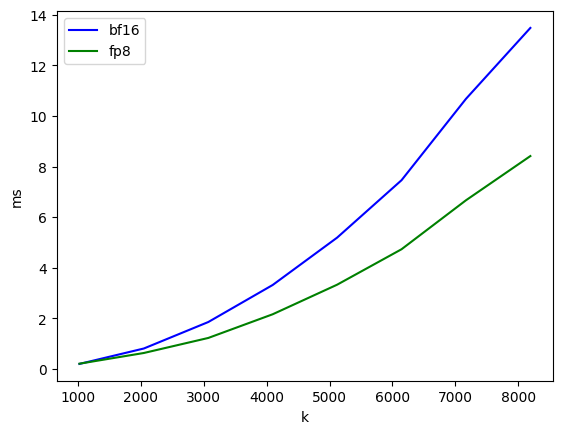

forward:
        k       bf16       fp8
0  1024.0   0.199337  0.209077
1  2048.0   0.809208  0.631715
2  3072.0   1.855335  1.226030
3  4096.0   3.320292  2.162524
4  5120.0   5.191652  3.331136
5  6144.0   7.461718  4.732620
6  7168.0  10.677553  6.667826
7  8192.0  13.482186  8.416808


In [23]:
torch.cuda.empty_cache()
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['k'],  # argument names to use as an x-axis for the plot
        x_vals=[1024 * i for i in range(1, 8+1)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['bf16', 'fp8'],  # possible values for `line_arg``
        line_names=[
            "bf16",
            "fp8",
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-')],  # line styles
        ylabel="ms",  # label name for the y-axis
        plot_name="forward",  # name for the plot. Used also as a file name for saving the plot.
        args={'m':4096, 'bs':4, 'factor':4},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(bs, m, k, factor, provider):
    n = k * factor
    device = 'cuda'
    dtype = torch.bfloat16
    x = torch.randn(bs*m, k, dtype=dtype, device=device) 
    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)
    if provider == 'bf16':
        fc = torch.nn.Linear(k,n, bias=False, dtype=dtype, device=device)
        ms = triton.testing.do_bench(lambda: fc(x))
    if provider == 'fp8':
        fc = DeepLinear(k,n, bias=False, dtype=dtype, device=device)
        ms = triton.testing.do_bench(lambda: fc(x))
    return ms
benchmark.run(show_plots=True, print_data=True)

# Backward

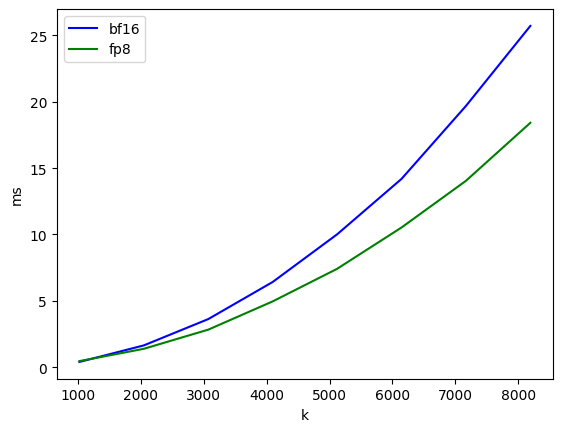

backward:
        k       bf16        fp8
0  1024.0   0.396847   0.458710
1  2048.0   1.643516   1.387062
2  3072.0   3.626404   2.829365
3  4096.0   6.422038   4.958855
4  5120.0  10.011893   7.413540
5  6144.0  14.191185  10.526588
6  7168.0  19.687916  14.045311
7  8192.0  25.718048  18.417318


In [25]:
torch.cuda.empty_cache()
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['k'],  # argument names to use as an x-axis for the plot
        x_vals=[1024 * i for i in range(1, 8+1)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['bf16', 'fp8'],  # possible values for `line_arg``
        line_names=[
            "bf16",
            "fp8",
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-')],  # line styles
        ylabel="ms",  # label name for the y-axis
        plot_name="backward",  # name for the plot. Used also as a file name for saving the plot.
        args={'m':4096, 'bs':4, 'factor':4},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(bs, m, k, factor, provider):
    n = k * factor
    device = 'cuda'
    dtype = torch.bfloat16
    x = torch.randn(bs*m, k, dtype=dtype, device=device)
    x.requires_grad_(True)
    
    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)
    if provider == 'bf16':
        fc = torch.nn.Linear(k,n, bias=False, dtype=dtype, device=device)
        y = fc(x)
        dy = torch.rand_like(y)
        ms = triton.testing.do_bench(lambda: y.backward(dy, retain_graph=True), grad_to_none=[x])
    if provider == 'fp8':
        fc = DeepLinear(k,n, bias=False, dtype=dtype, device=device)
        y = fc(x)
        dy = torch.rand_like(y)
        ms = triton.testing.do_bench(lambda: y.backward(dy, retain_graph=True), grad_to_none=[x])
    return ms
benchmark.run(show_plots=True, print_data=True)